In [34]:
!pip install yfinance plotly mplfinance --quiet

import yfinance as yf
import mplfinance as mpf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
import matplotlib.pyplot as plt
import statistics

PS-1

Q1) Leverage less than 1 mean some one has less assets than the equity it holds. This financially doesn't make sense becoz equity = assets - liability this equation must always hold true as the it is multiplied with the captial we have if we leverage less than 1 then the capital we truely have is less than we have for now .\
Q2) In static stoploss we have a fixed stop loss value that does not change with the price of the stocks where as in trailinf stop loss we a stop loss as fixed percentage of the stock price like if the stock price is increasing the % portion to be considered as stop loss is fixed
- in trending market trailing stop loss is good but in volatile market static stop loss is better.\
Q3) trailing take profit is a method where we have a fixed % of target to achieve for the dynamic stock price. Yes it is same as trailing stop loss.\
Q4) in Volatile markets trade may remain open even after reaching stop loss

PS-2

In [35]:
def download_flat_yf(ticker, start, end, interval):
    data = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level=1)

    data.columns.name = None
    data.reset_index(inplace=True)
    data.columns = [col.lower() for col in data.columns]
    if data.columns[0] in ['date', 'datetime']:
        data.rename(columns={data.columns[0]: 'datetime'}, inplace=True)
    data.loc[:,'datetime'] = pd.to_datetime(data['datetime'])

    return data

stock_symbol = 'ITC.NS'
data = download_flat_yf(stock_symbol, start='2020-06-01', end='2025-06-01', interval='1d')
data.head()

,datetime,close,high,low,open,volume
0,2020-06-01,158.565262,162.281324,157.339749,158.921053,28508405
1,2020-06-02,155.956100,159.632627,155.521239,159.632627,22631373
2,2020-06-03,155.521225,158.841961,154.651515,158.130379,18979188
3,2020-06-04,158.248993,160.107030,154.177140,156.351433,21996048
4,2020-06-05,158.130371,159.711675,157.062986,159.553547,14629659


In [36]:
fig = go.Figure(data=[
    go.Candlestick(x=data.index,
                   open=data['open'],
                   high=data['high'],
                   low=data['low'],
                   close=data['close'])
              ])
fig.update_layout(title=f"Candlestick Chart - {stock_symbol}", xaxis_title='Date', yaxis_title='Price')
fig.show()

In [37]:
def hammer(open_, high, low, close):
    body = abs(close - open_)
    lower_wick = min(open_, close) - low
    upper_wick = high - max(open_, close)
    return (
        body < (high - low) * 0.3 and
        lower_wick > body * 2 and
        upper_wick < body
    )

data['hammer'] = data.apply(lambda row: hammer(row['open'], row['high'], row['low'], row['close']), axis=1)
def dogi(open_,high,low,close):
    body = abs(close - open_)
    lower_wick = min(open_, close) - low
    upper_wick = high - max(open_, close)
    return (
        0.001<body and
        body<0.1
    )
data['dogi'] = data.apply(lambda row: dogi(row['open'], row['high'], row['low'], row['close']), axis=1)
def is_bullish_engulfing(prev, curr):
    return (
        prev['close'] < prev['open'] and
        curr['close'] > curr['open'] and
        curr['open'] < prev['close'] and
        curr['close'] > prev['open']
    )

def is_bearish_engulfing(prev, curr):
    return (
        prev['close'] > prev['open'] and
        curr['close'] < curr['open'] and
        curr['open'] > prev['close'] and
        curr['close'] < prev['open']
    )

In [38]:
hammer_dates = data[data['hammer']].index
hammer_prices = data[data['hammer']]['close']
dogi_dates = data[data['dogi']].index
dogi_prices = data[data['dogi']]['close']
data['bullish_engulfing'] = False
data['bearish_engulfing'] = False

for i in range(1, len(data)):
    prev = data.iloc[i - 1]
    curr = data.iloc[i]
    data.at[data.index[i], 'bullish_engulfing'] = is_bullish_engulfing(prev, curr)
    data.at[data.index[i], 'bearish_engulfing'] = is_bearish_engulfing(prev, curr)

In [39]:
bullish = data[data['bullish_engulfing']]
bearish = data[data['bearish_engulfing']]
fig = go.Figure(data=[
    go.Candlestick(x=data.index,
                   open=data['open'],
                   high=data['high'],
                   low=data['low'],
                   close=data['close'])
              ,
    go.Scatter(x=hammer_dates, y=hammer_prices, mode='markers', marker=dict(color='red', size=5), name='Hammer'),
    go.Scatter(x=dogi_dates, y=dogi_prices, mode='markers', marker=dict(color='green', size=5), name='Dogi'),
    go.Scatter(x=bullish.index, y=bullish['close'], mode='markers', marker=dict(color='blue', size=5), name='Bullish Engulfing'),
    go.Scatter(x=bearish.index, y=bearish['close'], mode='markers', marker=dict(color='orange', size=5), name='Bearish Engulfing')

    ])
fig.update_layout(title=f"Candlestick Chart - {stock_symbol}", xaxis_title='Date', yaxis_title='Price')
fig.show()

In [40]:
def Win_rate(n,data,pattern):
  wins = 0
  total = 0
  for i in range(len(data) - n):
      if data[pattern].iloc[i]:
          current_close = data['close'].iloc[i]
          close_n = data['close'].iloc[i+n]

          if close_n > current_close:
              wins += 1
          total += 1
  # Final win rate
  win_rate = wins / total if total > 0 else 0
  return win_rate


In [41]:
dogi_winrate_3= Win_rate(3,data,'dogi')
print(f"Dogi Win Rate n = 3: {dogi_winrate_3*100}")
hammer_winrate_3 = Win_rate(3,data,'hammer')
print(f"Hammer Win Rate n = 3: {hammer_winrate_3*100}")
bullish_winrate_3 = Win_rate(3,data,'bullish_engulfing')
print(f"Bullish Win Rate n = 3: {bullish_winrate_3*100}")
bearish_winrate_3 = Win_rate(3,data,'bearish_engulfing')
print(f"Bearish Win Rate for n = 3: {bearish_winrate_3*100}")
dogi_winrate = Win_rate(5,data,'dogi')
print(f"Dogi Win Rate n = 5: {dogi_winrate*100}")
hammer_winrate = Win_rate(5,data,'hammer')
print(f"Hammer Win Rate n = 5: {hammer_winrate*100}")
bullish_winrate = Win_rate(5,data,'bullish_engulfing')
print(f"Bullish Win Rate n = 5: {bullish_winrate*100}")
bearish_winrate = Win_rate(5,data,'bearish_engulfing')
print(f"Bearish Win Rate for n = 5: {bearish_winrate*100}")

Dogi Win Rate n = 3: 48.484848484848484
Hammer Win Rate n = 3: 54.54545454545454
Bullish Win Rate n = 3: 70.96774193548387
Bearish Win Rate for n = 3: 43.42105263157895
Dogi Win Rate n = 5: 51.515151515151516
Hammer Win Rate n = 5: 51.515151515151516
Bullish Win Rate n = 5: 54.83870967741935
Bearish Win Rate for n = 5: 52.63157894736842


In [42]:

def baseline_win_rate( df, n,pattern):
    indices = data.index
    pattern_indices = data.index[data[pattern]=='True']
    M_indices= len(pattern_indices)
    valid_random_pool = np.setdiff1d(np.arange(len(data) - 3),indices)
    random_indices = np.random.choice(valid_random_pool, size=M_indices, replace=False)
    valid = [idx for idx in indices if idx + n < len(df)]
    wins = sum(data['close'].iloc[idx + n] > data['close'].iloc[idx] for idx in valid)
    return wins / len(valid) if valid else 0

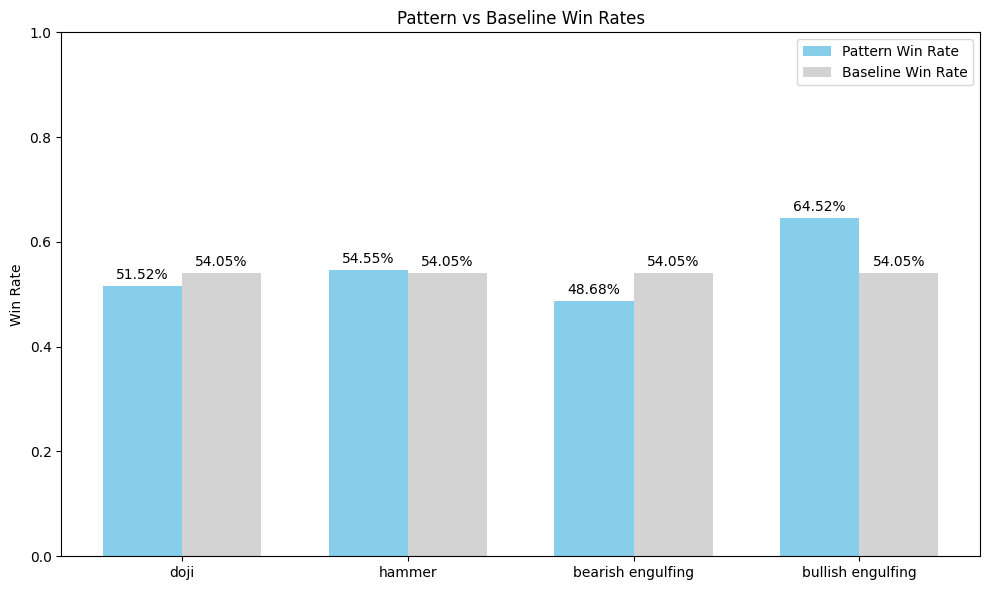

In [43]:
import matplotlib.pyplot as plt
import numpy as np
n = 6
# Compute actual win rates (call your functions here)
dogi_winrate_3 = Win_rate( n,data, 'dogi')                 # <-- You must have this function
hammer_winrate_3 = Win_rate( n,data, 'hammer')
bearish_winrate_3 = Win_rate( n, data,'bearish_engulfing')
bullish_winrate_3 =Win_rate( n,data, 'bullish_engulfing')

# Compute baselines (call function!)
base_line_dogi = baseline_win_rate(data, n, 'dogi')
base_line_hammer = baseline_win_rate(data, n, 'hammer')
base_line_bear = baseline_win_rate(data, n, 'bearish_engulfing')
base_line_bull = baseline_win_rate(data, n, 'bullish_engulfing')

# Labels and data
patterns = ['doji', 'hammer', 'bearish engulfing', 'bullish engulfing']
pattern_win_rates = [dogi_winrate_3, hammer_winrate_3, bearish_winrate_3, bullish_winrate_3]
baseline_win_rates = [base_line_dogi, base_line_hammer, base_line_bear, base_line_bull]

# Plotting
x = np.arange(len(patterns))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, pattern_win_rates, width, label='Pattern Win Rate', color='skyblue')
bars2 = ax.bar(x + width/2, baseline_win_rates, width, label='Baseline Win Rate', color='lightgray')

# Axis labeling and ticks
ax.set_ylabel('Win Rate')
ax.set_title('Pattern vs Baseline Win Rates')
ax.set_xticks(x)
ax.set_xticklabels(patterns)
ax.set_ylim(0, 1)
ax.legend()

# Annotate bars with % values
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2%}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


1) baseline win rate over performs dogi and bearish engulfing where as it underperform in case of bullish and hammer \
2) on changing the value of n to 5 it out perform most of the pattern \
3) bullish engulfing is the most consistant over the values of n

PS-3

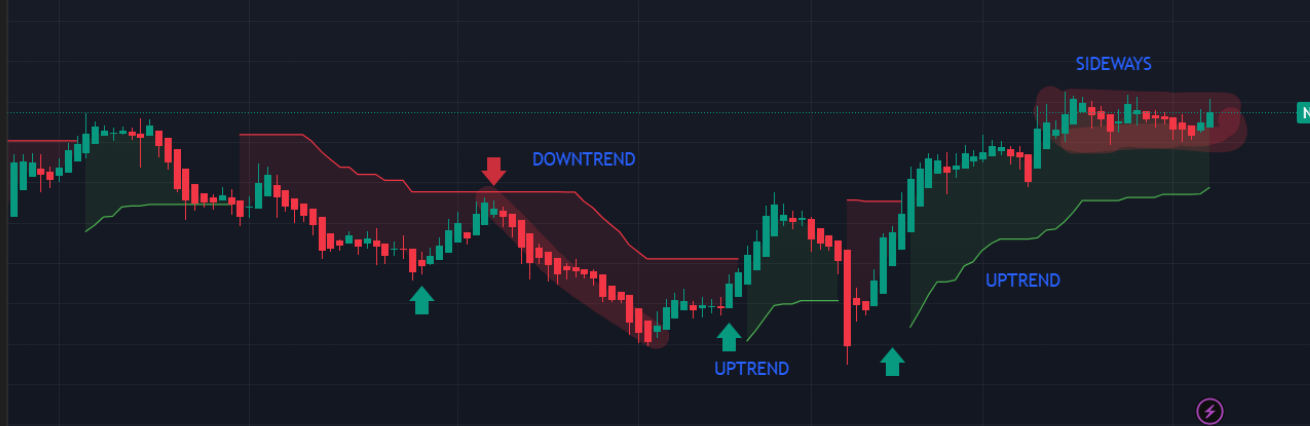

Q 1

1) First green arrow is a normal spining top type pattern but before there has been a engulfing so this  means that bulls are entering the market so the market is most likely to move up\
2) First red arrow its similar to the first green arrow but this time there is bearish engulfing thats the only diff\
3) Second green arrow market was moving sideways before that but if we see a little back there has been a engulfing and the arrow points at a dogi pattern so we can make a entry call \
4) Third green arrow there has been engulfing again

Q-2

Moving average is one of the main technical indicator and super trend indicator

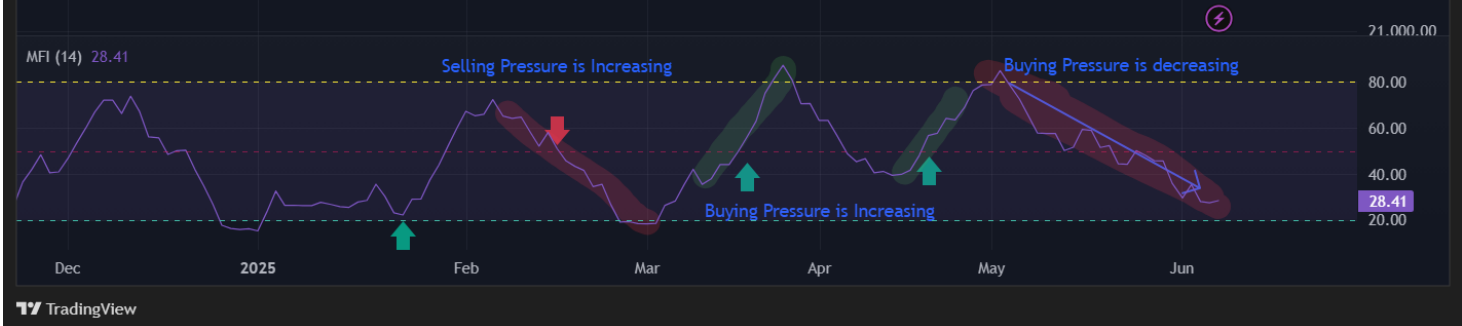

Q3

as we know that MFI tells us buying and selling sentiments os the market so the first green arrow tells about the stock is very near to the 20 mark so tell likely to go up so more people are buying
and first red arrow tells that the as it has touched the 80 line so stock prices are likely oning down so people would be more into seeling and similarly we say for other annotations and arrows

2

Q1

1) long postion means that we want to buy stock a less price then expecting it to grow further so you can get profit so entering the long postion we need to see some bullish pattern near to the support line and exiting the long position we need to see some bearish pattern near the resistance line so we can sell the stock \
2) Short position means selling the stock which you don't own at a higher price and then buying it back when the price is lower so that the difference is considered as profit for entering a short postion we need to sell it near resisance line buy seeing some bearish pattern and then buy it again when it is near to the support line and we see some bullish pattern  

Q2

Moving average can be good rule of variants and using ADX can be good choice

In [44]:
stock_symbol = 'CAMS.NS'
data = download_flat_yf(stock_symbol, start='2020-06-01', end='2025-06-01', interval='1d')
data.head()

,datetime,close,high,low,open,volume
0,2020-10-05,1301.218750,1382.556504,1272.991919,1318.489077,638095
1,2020-10-06,1317.932251,1338.777336,1301.079706,1309.204200,542573
2,2020-10-07,1282.694946,1321.878285,1258.832194,1319.417701,283115
3,2020-10-08,1239.472656,1290.587255,1230.466008,1285.991159,287027
4,2020-10-09,1241.236938,1273.177713,1202.425027,1231.301776,617512


In [45]:
#@title Backtest Engine
def perform_backtest(dataframe, lev=1, initial_capital=100000 , lot_size=1, tsl=100):
    """
    Backtesting engine for trading strategies.

    Parameters:
    - dataframe: Pandas DataFrame with columns ['timestamp', 'close', 'high', 'signals']
                 signals: 1 for long entry/close short, -1 for short entry/close long, 0 no action
    - lev: Leverage multiplier for position sizing (default 1)
    - initial_capital: Starting capital for backtest (default 100000)
    - lot_size: Number of units per lot (default 1)
    - tsl: Trailing stop loss percentage (default 100%)

    Returns:
    - trade_log: DataFrame summarizing all trades with entry/exit dates, profit/loss, size and type
    """
    capital_list = [initial_capital]
    trade = 0  # 0 = no open trade, 1 = long trade open, -1 = short trade open
    position_size = 0
    trade_profit = []
    entry, exit = [], []
    entry_index, exit_index = [], []
    nol, nos = 0, 0  # Number of long and short trades
    long_profit, short_profit = [], []
    trade_type = []
    position_size_list = []

    # Calculate benchmark returns over entire backtest period
    benchmark_returns = (dataframe.loc[dataframe.index[-1], 'close'] / dataframe.loc[dataframe.index[0], 'close'] - 1) * 100

    # Calculate backtest period in years and months
    backtest_period = dataframe.loc[dataframe.index[-1], 'timestamp'] - dataframe.loc[dataframe.index[0], 'timestamp']
    total_days = backtest_period.days
    years = total_days // 365
    remaining_days = total_days % 365
    months = remaining_days // 30

    max_price = 0  # For tracking trailing stop price

    for i in range(len(dataframe)):
        date = dataframe.loc[i, 'timestamp']
        current_price = dataframe.loc[i, 'close']
        high_price = dataframe.loc[i, 'high']

        # Stop if capital is exhausted
        if capital_list[-1] <= 0:
            print(f'Complete capital lost on {date}')
            break

        # Open Long trade if no trade is open and signal is long (1)
        if trade == 0 and dataframe.loc[i, 'signals'] == 1:
            position_size = (capital_list[-1] * lev) // (current_price * lot_size)
            cost = position_size * current_price * lot_size
            if cost > 0:
                position_size_list.append(position_size * lot_size)
                trade = 1
                entry.append(date)
                entry_index.append(i)
                max_price = current_price  # Initialize max price for trailing stop
            else:
                position_size = 0

        # Open Short trade if no trade is open and signal is short (-1)
        elif trade == 0 and dataframe.loc[i, 'signals'] == -1:
            position_size = (capital_list[-1] * lev) // (current_price * lot_size)
            cost = position_size * current_price * lot_size
            if cost > 0:
                position_size_list.append(position_size * lot_size)
                trade = -1
                entry.append(date)
                entry_index.append(i)
                max_price = current_price  # Initialize min price for trailing stop (will update below)
            else:
                position_size = 0

        # Manage open trade and trailing stop
        elif trade != 0:
            if trade == 1:
                # Update max price seen during long trade for trailing stop loss
                max_price = max(max_price, high_price)
                # Check if current close triggers trailing stop loss exit
                if dataframe.loc[i, 'close'] <= (1 - tsl / 100) * max_price:
                    # Set signal to close long and open short (or just close)
                    dataframe.loc[i, 'signals'] = -1  # force exit long
                    max_price = 0

            elif trade == -1:
                # For short, track minimum price for trailing stop loss
                max_price = min(max_price, high_price)
                # Check if current close triggers trailing stop loss exit
                if dataframe.loc[i, 'close'] >= (1 + tsl / 100) * max_price:
                    dataframe.loc[i, 'signals'] = 1  # force exit short
                    max_price = 0

            # If signal indicates closing current trade (opposite signal)
            if dataframe.loc[i, 'signals'] * trade == -1:
                exit.append(date)
                exit_index.append(i)
                if trade == 1:
                    nol += 1
                    profit = lot_size * current_price * position_size - cost
                else:
                    nos += 1
                    profit = cost - lot_size * current_price * position_size

                capital_list.append(capital_list[-1] + profit)
                trade_profit.append(profit)

                if trade == 1:
                    long_profit.append(profit)
                else:
                    short_profit.append(profit)

                trade_type.append('Long' if trade == 1 else 'Short')
                trade = 0
                position_size = 0
                cost = 0

    # Close any open trade at last price in dataframe
    if trade != 0:
        exit.append(dataframe.iloc[-1]['timestamp'])
        exit_index.append(len(dataframe) - 1)
        if trade == 1:
            nol += 1
            profit = dataframe.iloc[-1]['close'] * position_size * lot_size - cost
            trade_type.append('Long')
        else:
            nos += 1
            profit = cost - dataframe.iloc[-1]['close'] * position_size * lot_size
            trade_type.append('Short')
        capital_list.append(capital_list[-1] + profit)
        trade_profit.append(profit)

    # Calculate returns for performance metrics
    returns = np.diff(capital_list) / capital_list[:-1]
    downside_returns = returns[returns < 0]

    sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252) if len(returns) > 0 and np.std(returns) > 0 else float('nan')
    sortino_ratio = np.mean(returns) / np.std(downside_returns) * np.sqrt(252) if len(downside_returns) > 0 and np.std(downside_returns) > 0 else float('nan')

    number_of_trades = len(trade_profit)

    capital_series = pd.Series(capital_list)
    running_max = capital_series.cummax()
    drawdowns = (capital_series - running_max) / running_max
    drawdowns = drawdowns[drawdowns <= 0]

    print(f'BACKTEST RESULTS:')
    if number_of_trades == 0:
        print('No trades taken')
        return

    print(f"Backtest Period: {years} years and {months} months")
    print(f'Benchmark Returns: {benchmark_returns * lev:.2f} %')
    print(f'Initial Capital: {capital_list[0]}')
    print(f'Final Capital: {capital_list[-1]:.2f}')
    print(f'Profit percentage: {(capital_list[-1] - capital_list[0]) / capital_list[0] * 100:.2f} %')
    print(f'Leverage applied: {lev}')
    print(f'Maximum Portfolio balance: {max(capital_list):.2f}')
    print(f'Minimum Portfolio balance: {min(capital_list):.2f}')
    print(f'Number of trades: {number_of_trades}')

    win = sum(1 for profit in trade_profit if profit > 0)
    print(f'Winning Trades: {win}')
    print(f'Losing Trades: {number_of_trades - win}')
    print(f'Win Rate: {win / number_of_trades * 100:.2f} %')

    try:
        avg_profit = statistics.mean([x for x in trade_profit if x > 0])
    except:
        avg_profit = 0
    try:
        avg_loss = statistics.mean([x for x in trade_profit if x <= 0])
    except:
        avg_loss = 0

    print(f'Average Profit: {avg_profit:.2f}')
    print(f'Average Loss: {avg_loss:.2f}')
    print(f'No of Long Trades: {nol}')
    print(f'No of Short Trades: {nos}')
    print(f'Average drawdown: {np.mean(drawdowns) * 100:.2f} %')
    print(f'Maximum drawdown: {np.min(drawdowns) * 100:.2f} %')
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
    print(f'Sortino Ratio: {sortino_ratio:.2f}')

    # Calculate and print holding times if any trades happened
    if entry and exit:
        holding_times = [(exit[i] - entry[i]) for i in range(len(entry))]
        max_holding_time = max(holding_times)
        days = max_holding_time.days
        hours, remainder = divmod(max_holding_time.seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f'Maximum Holding Time: {days} days, {hours:02}:{minutes:02}:{seconds:02}')

        avg_holding_time = sum(holding_times, pd.Timedelta(0)) / len(holding_times)
        days_avg = avg_holding_time.days
        hours_avg, remainder_avg = divmod(avg_holding_time.seconds, 3600)
        minutes_avg, seconds_avg = divmod(remainder_avg, 60)
        print(f'Average Holding Time: {days_avg} days, {hours_avg:02}:{minutes_avg:02}:{seconds_avg:02}')

    # Plotting equity curve and price chart with entry/exit points
    fig = sp.make_subplots(
        rows=2, cols=1, shared_xaxes=True,
        subplot_titles=('Equity Curve', 'Price Action with Entry and Exit Points'),
        vertical_spacing=0.1
    )

    # Equity Curve
    fig.add_trace(go.Scatter(
        y=capital_list,
        mode='lines',
        name='Capital',
        line=dict(color='green')
    ), row=1, col=1)

    # Price chart
    fig.add_trace(go.Scatter(
        x=dataframe['timestamp'],
        y=dataframe['close'],
        mode='lines',
        name='Close Price',
        line=dict(color='blue')
    ), row=2, col=1)

    # Entry markers
    fig.add_trace(go.Scatter(
        x=[dataframe['timestamp'].iloc[i] for i in entry_index],
        y=[dataframe['close'].iloc[i] for i in entry_index],
        mode='markers',
        marker=dict(symbol='triangle-up', color='green', size=10),
        name='Entry'
    ), row=2, col=1)

    # Exit markers
    fig.add_trace(go.Scatter(
        x=[dataframe['timestamp'].iloc[i] for i in exit_index],
        y=[dataframe['close'].iloc[i] for i in exit_index],
        mode='markers',
        marker=dict(symbol='triangle-down', color='red', size=10),
        name='Exit'
    ), row=2, col=1)

    fig.update_layout(
        height=800,
        title_text='Backtest Visualizations',
        showlegend=True,
        template='plotly_white'
    )

    fig.update_xaxes(title_text='Time', row=2, col=1)
    fig.update_yaxes(title_text='Capital', row=1, col=1)
    fig.update_yaxes(title_text='Price', row=2, col=1)

    fig.show()

    # Prepare trade log DataFrame
    trade_log = pd.DataFrame({
        'Entry Candle': entry,
        'Exit Candle': exit,
        'PnL': trade_profit,
        'Number of units': position_size_list,
        'Trade type': trade_type
    })

    return trade_log

In [46]:
def calculate_macd(data, short_window, long_window, signal_window):
  data['Short_EMA'] = data['close'].ewm(span=short_window, adjust=False).mean()
  data['Long_EMA'] = data['close'].ewm(span=long_window, adjust=False).mean()
  data['MACD'] = data['Short_EMA'] - data['Long_EMA']
  data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
  data['MACD_Histogram'] = data['MACD'] - data['Signal_Line']
  return data

# Calculate MACD with typical parameters (12, 26, 9)
data = calculate_macd(data, short_window=12, long_window=26, signal_window=9)

# Plot MACD and Signal Line
fig_macd = go.Figure()
fig_macd.add_trace(go.Scatter(x=data.index, y=data['MACD'], mode='lines', name='MACD'))
fig_macd.add_trace(go.Scatter(x=data.index, y=data['Signal_Line'], mode='lines', name='Signal Line'))

# Plot MACD Histogram
fig_macd.add_trace(go.Bar(x=data.index, y=data['MACD_Histogram'], name='MACD Histogram'))

fig_macd.update_layout(title=f"MACD Indicator - {stock_symbol}", xaxis_title='Date', yaxis_title='Value')
fig_macd.show()
data.head()

,datetime,close,high,low,open,volume,Short_EMA,Long_EMA,MACD,Signal_Line,MACD_Histogram
0,2020-10-05,1301.218750,1382.556504,1272.991919,1318.489077,638095,1301.218750,1301.218750,0.000000,0.000000,0.000000
1,2020-10-06,1317.932251,1338.777336,1301.079706,1309.204200,542573,1303.790058,1302.456787,1.333271,0.266654,1.066617
2,2020-10-07,1282.694946,1321.878285,1258.832194,1319.417701,283115,1300.544656,1300.992947,-0.448291,0.123665,-0.571956
3,2020-10-08,1239.472656,1290.587255,1230.466008,1285.991159,287027,1291.148964,1296.435888,-5.286925,-0.958453,-4.328472
4,2020-10-09,1241.236938,1273.177713,1202.425027,1231.301776,617512,1283.470191,1292.347077,-8.876887,-2.542140,-6.334747


In [47]:
# Identify crossover points
data['MACD_Previous'] = data['MACD'].shift(1)
data['Signal_Previous'] = data['Signal_Line'].shift(1)

# Crossover condition: MACD crosses above Signal Line (Buy Signal)
buy_signals = data[(data['MACD'] > data['Signal_Line']) & (data['MACD_Previous'] <= data['Signal_Previous'])]

# Crossover condition: MACD crosses below Signal Line (Sell Signal)
sell_signals = data[(data['MACD'] < data['Signal_Line']) & (data['MACD_Previous'] >= data['Signal_Previous'])]

# Add crossover points to the MACD plot
fig_macd.add_trace(go.Scatter(
    x=buy_signals.index,
    y=buy_signals['MACD'],
    mode='markers',
    marker=dict(color='green', size=10, symbol='circle'),
    name='Buy Signal'
))

fig_macd.add_trace(go.Scatter(
    x=sell_signals.index,
    y=sell_signals['MACD'],
    mode='markers',
    marker=dict(color='red', size=10, symbol='circle'),
    name='Sell Signal'
))

fig_macd.update_layout(title=f"MACD Indicator with Crossovers - {stock_symbol}", xaxis_title='Datetime', yaxis_title='Value')
fig_macd.show()
data.head()

,datetime,close,high,low,open,volume,Short_EMA,Long_EMA,MACD,Signal_Line,MACD_Histogram,MACD_Previous,Signal_Previous
0,2020-10-05,1301.218750,1382.556504,1272.991919,1318.489077,638095,1301.218750,1301.218750,0.000000,0.000000,0.000000,NaN,NaN
1,2020-10-06,1317.932251,1338.777336,1301.079706,1309.204200,542573,1303.790058,1302.456787,1.333271,0.266654,1.066617,0.000000,0.000000
2,2020-10-07,1282.694946,1321.878285,1258.832194,1319.417701,283115,1300.544656,1300.992947,-0.448291,0.123665,-0.571956,1.333271,0.266654
3,2020-10-08,1239.472656,1290.587255,1230.466008,1285.991159,287027,1291.148964,1296.435888,-5.286925,-0.958453,-4.328472,-0.448291,0.123665
4,2020-10-09,1241.236938,1273.177713,1202.425027,1231.301776,617512,1283.470191,1292.347077,-8.876887,-2.542140,-6.334747,-5.286925,-0.958453


In [48]:
data['signals'] = 0

# Example: MACD Buy Signal - MACD crosses above Signal Line
data.loc[(data['MACD'] > data['Signal_Line']) & (data['MACD_Previous'] <= data['Signal_Previous']), 'signals'] = 1

# Example: MACD Sell Signal - MACD crosses below Signal Line
data.loc[(data['MACD'] < data['Signal_Line']) & (data['MACD_Previous'] >= data['Signal_Previous']), 'signals'] = -1

In [49]:
data.head()

,datetime,close,high,low,open,volume,Short_EMA,Long_EMA,MACD,Signal_Line,MACD_Histogram,MACD_Previous,Signal_Previous,signals
0,2020-10-05,1301.218750,1382.556504,1272.991919,1318.489077,638095,1301.218750,1301.218750,0.000000,0.000000,0.000000,NaN,NaN,0
1,2020-10-06,1317.932251,1338.777336,1301.079706,1309.204200,542573,1303.790058,1302.456787,1.333271,0.266654,1.066617,0.000000,0.000000,1
2,2020-10-07,1282.694946,1321.878285,1258.832194,1319.417701,283115,1300.544656,1300.992947,-0.448291,0.123665,-0.571956,1.333271,0.266654,-1
3,2020-10-08,1239.472656,1290.587255,1230.466008,1285.991159,287027,1291.148964,1296.435888,-5.286925,-0.958453,-4.328472,-0.448291,0.123665,0
4,2020-10-09,1241.236938,1273.177713,1202.425027,1231.301776,617512,1283.470191,1292.347077,-8.876887,-2.542140,-6.334747,-5.286925,-0.958453,0


In [50]:
def remove_redundant_signals(data):
    prev_signal = 0
    prev_i = 0
    trade = 0
    for i in range(len(data)):
        if prev_signal == 0 and data.loc[i, 'signals'] != 0:
            prev_signal = data.loc[i, 'signals']
            prev_i = i
        elif prev_signal != 0:
            if data.loc[i, 'signals'] * prev_signal > 0:
                data.loc[i, 'signals'] = 0  # same direction → redundant
            elif data.loc[i, 'signals'] * prev_signal < 0:
                # Direction changed → new valid trade
                trade = (
                    data.loc[prev_i, 'close'] - data.loc[i, 'close']
                    if prev_signal < 0
                    else data.loc[i, 'close'] - data.loc[prev_i, 'close']
                )
                prev_signal = data.loc[i, 'signals']
                prev_i = i
    return data

In [52]:
dataframe = data.copy()
dataframe.rename(columns={'datetime':'timestamp'},inplace=True)
perform_backtest(dataframe)

BACKTEST RESULTS:
Backtest Period: 4 years and 7 months
Benchmark Returns: 204.41 %
Initial Capital: 100000
Final Capital: 73060.66
Profit percentage: -26.94 %
Leverage applied: 1
Maximum Portfolio balance: 130564.38
Minimum Portfolio balance: 69193.86
Number of trades: 56
Winning Trades: 20
Losing Trades: 36
Win Rate: 35.71 %
Average Profit: 4781.12
Average Loss: -3404.49
No of Long Trades: 56
No of Short Trades: 0
Average drawdown: -26.58 %
Maximum drawdown: -47.00 %
Sharpe Ratio: -0.78
Sortino Ratio: -1.99
Maximum Holding Time: 60 days, 00:00:00
Average Holding Time: 15 days, 14:34:17


,Entry Candle,Exit Candle,PnL,Number of units,Trade type
0,2020-10-06,2020-10-07,-2642.797852,75.0,Long
1,2020-10-23,2020-10-29,-3778.555054,77.0,Long
2,2020-11-11,2021-01-08,36985.729980,78.0,Long
3,2021-02-11,2021-02-18,-5757.858887,70.0,Long
4,2021-03-04,2021-03-10,-3548.013916,70.0,Long
5,2021-04-16,2021-05-07,8158.426514,62.0,Long
6,2021-05-10,2021-05-14,-4542.790527,58.0,Long
7,2021-05-24,2021-05-27,-5697.643555,52.0,Long
8,2021-05-28,2021-06-03,105.395508,50.0,Long
9,2021-06-07,2021-06-22,122.805176,46.0,Long


In [53]:
data.head()

,datetime,close,high,low,open,volume,Short_EMA,Long_EMA,MACD,Signal_Line,MACD_Histogram,MACD_Previous,Signal_Previous,signals
0,2020-10-05,1301.218750,1382.556504,1272.991919,1318.489077,638095,1301.218750,1301.218750,0.000000,0.000000,0.000000,NaN,NaN,0
1,2020-10-06,1317.932251,1338.777336,1301.079706,1309.204200,542573,1303.790058,1302.456787,1.333271,0.266654,1.066617,0.000000,0.000000,1
2,2020-10-07,1282.694946,1321.878285,1258.832194,1319.417701,283115,1300.544656,1300.992947,-0.448291,0.123665,-0.571956,1.333271,0.266654,-1
3,2020-10-08,1239.472656,1290.587255,1230.466008,1285.991159,287027,1291.148964,1296.435888,-5.286925,-0.958453,-4.328472,-0.448291,0.123665,0
4,2020-10-09,1241.236938,1273.177713,1202.425027,1231.301776,617512,1283.470191,1292.347077,-8.876887,-2.542140,-6.334747,-5.286925,-0.958453,0


In [54]:
def calculate_atr(data, window=14):
    high_low = data['high'] - data['low']
    high_close = np.abs(data['high'] - data['close'].shift())
    low_close = np.abs(data['low'] - data['close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    data['ATR'] = tr.rolling(window=window).mean()
    return data

In [55]:
data = calculate_atr(data, window=14)

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime         1151 non-null   datetime64[ns]
 1   close            1151 non-null   float64       
 2   high             1151 non-null   float64       
 3   low              1151 non-null   float64       
 4   open             1151 non-null   float64       
 5   volume           1151 non-null   int64         
 6   Short_EMA        1151 non-null   float64       
 7   Long_EMA         1151 non-null   float64       
 8   MACD             1151 non-null   float64       
 9   Signal_Line      1151 non-null   float64       
 10  MACD_Histogram   1151 non-null   float64       
 11  MACD_Previous    1150 non-null   float64       
 12  Signal_Previous  1150 non-null   float64       
 13  signals          1151 non-null   int64         
 14  ATR              1138 non-null   float64

In [59]:
def macd_atr_strategy(data):
    data['signals'] = 0

    # Rising ATR
    data['ATR_Rising'] = data['ATR'] > data['ATR'].shift(1)

    # Long Entry
    data.loc[
        (data['MACD'] > data['Signal_Line']) &
        (data['MACD'] > data['MACD'].shift(1)) &
        (data['ATR_Rising']),
        'signals'
    ] = 1

    # Long Exit
    data.loc[
        (data['signals'].shift() == 1) &
        ((data['MACD'] < data['Signal_Line']) | (~data['ATR_Rising'])),
        'signals'
    ] = -1

    # Short Entry
    data.loc[
        (data['MACD'] < data['Signal_Line']) &
        (data['MACD'] < data['MACD'].shift(1)) &
        (data['ATR_Rising']),
        'signals'
    ] = -1

    # Short Exit
    data.loc[
        (data['signals'].shift() == -1) &
        ((data['MACD'] > data['Signal_Line']) | (~data['ATR_Rising'])),
        'signals'
    ] = 1

    remove_redundant_signals(data)
    print("Number of non-zero signals:", (data['signals'] != 0).sum(), "\n")
    return data


In [61]:
data = macd_atr_strategy(data)
data.rename(columns={'datetime':'timestamp'},inplace=True)
dataframe = data[['timestamp','open','high','low','close','volume','signals']]
perform_backtest(dataframe)

Number of non-zero signals: 332 

BACKTEST RESULTS:
Backtest Period: 4 years and 7 months
Benchmark Returns: 204.41 %
Initial Capital: 100000
Final Capital: 40122.11
Profit percentage: -59.88 %
Leverage applied: 1
Maximum Portfolio balance: 100000.00
Minimum Portfolio balance: 36305.88
Number of trades: 166
Winning Trades: 79
Losing Trades: 87
Win Rate: 47.59 %
Average Profit: 793.22
Average Loss: -1408.53
No of Long Trades: 0
No of Short Trades: 166
Average drawdown: -41.50 %
Maximum drawdown: -63.69 %
Sharpe Ratio: -2.64
Sortino Ratio: -2.61
Maximum Holding Time: 43 days, 00:00:00
Average Holding Time: 2 days, 22:50:36


,Entry Candle,Exit Candle,PnL,Number of units,Trade type
0,2020-11-03,2020-11-04,-142.078247,85.0,Short
1,2020-11-06,2020-11-17,-6263.024414,84.0,Short
2,2020-12-03,2020-12-04,-1123.599976,69.0,Short
3,2020-12-14,2020-12-15,21.217041,65.0,Short
4,2021-01-13,2021-01-14,1449.102295,53.0,Short
...,...,...,...,...,...
161,2025-04-08,2025-04-09,-189.199463,11.0,Short
162,2025-04-23,2025-04-24,504.900879,9.0,Short
163,2025-05-06,2025-05-07,-382.800537,11.0,Short
164,2025-05-08,2025-05-13,-627.000000,11.0,Short


It can underperform when market is sideways becoz macd is momentum based so it goes back and fourth in sideways market condition and with large volume of candles ATR can give false results 

To enhance the macd + atr strategy in volatile or sideways markets,use higher timeframes,normalize ATR,and require MACD histogram and ADX filters. These adjustments reduce false signals,improve trend confirmation,and adapt to market regimes,making the strategy more robust across varying volatility conditions.